<a href="https://colab.research.google.com/github/zeusunderthehood/mkrad_bot/blob/main/Mkrad_Botv0_3ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
  !pip install langgraph langchain_groq langchain langchain_core langchain_community flask pydantic[email] mysql-connector-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.5/127.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 15.1 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/zeusunderthehood/mkrad_bot.git

Cloning into 'mkrad_bot'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 23 (delta 6), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (23/23), 60.96 KiB | 1.35 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [3]:
import os
from langchain.agents import tool
import re
from mkrad_bot.database import UserFetchFormat,connect_to_localDB,connect_to_rds
from mkrad_bot.tools import check_user
from typing import TypedDict, List, Optional, Dict, Any
from langchain_core.messages import AIMessage, ToolMessage, BaseMessage, SystemMessage, HumanMessage
from langgraph.graph import StateGraph, END
from google.colab import userdata
from langchain_groq import ChatGroq
from dotenv import load_dotenv


In [5]:
from mkrad_bot.tools import check_user
check_user("2818148527")

{'name': 'Kathy Dumont',
 'phone_number': '2818148527',
 'address': '1014 Rosita Street, Arlington, TX, USA ',
 'pincode': '76002',
 'email_id': 'krdumont4@gmail.com',
 'city': 'Arlington'}

In [6]:
class GraphState(TypedDict):
    input: str
    messages: List[BaseMessage]
    user_data: Optional[Dict[str, Any]]
    user_exists: Optional[bool]
    current_field: Optional[str]
    confirmation_asked: Optional[bool]
    phone_processed: Optional[bool]


# Define fields to collect
FIELDS_TO_COLLECT = [
    ("phone_number", "Please enter your phone number."),
    ("email_id", "What is your email address?"),
    ("name", "What is your full name?"),
    ("address", "Please provide your complete address."),
    ("city", "Which city do you live in?"),
    ("state", "Which state do you live in?"),
    ("pincode", "What is your area pincode?")
]


load_dotenv()
from google.colab import userdata
os.environ['GROQ_API_KEY'] = userdata.get("GROQ_API_KEY")
model = "Llama3-8b-8192"
llm = ChatGroq(model=model)
llmt = llm.bind_tools(tools=[check_user])

dialogs=("Hi, Welcome to MKRAD Landscaping services. Would you like to book a service with us?"
                "\n\n"
                "User: Yes \n\n"
                "Bot: Sure Can you please help me with your number? \n\n"
                "User: 1234567890 \n\n"
                "Bot:Looks like you are not registered with us. Please provide your full name. \n\n"
                "User: Pratik Kumar \n\n"
                "Bot: Can you please provide your phone number? \n\n"
                "User: 1234567890\n\n"
                "Bot:Can you please provide your email id? \n\n"
                "User:zee.pratik@gmail.com \n\n"
                "Bot: Can you please provide your address? \n\n"
                "User: 123, ABC Street \n\n"
                "Bot: Can you please provide your city, State? \n\n"
                "User: New York, NY \n\n"
                "Bot: Can you please provide your pincode? \n\n"
                "User: 123456 \n\n"
                "Bot:What service would you like to book? \n\n"
                "User: I would like to book a lawn mowing service. \n\n"
                "Bot: Sure, Can you please confirm the details \n* Name : Pratik Kumar \n* Phone Number : 9205986849 \n* Email ID : zee.pratik@gmail.com \n* Address : 123, ABC Street \n* City : New York \n* State : NY \n* Pincode : 123456 \n\n"
                "User: Looks good to me. \n\n"
                "Bot: Great! I will now send you a confirmation email for further communication. Thank you for choosing MKRAD's service \n\n")

system_prompt = (
    "You are an assistant for MKRAD Landscaping Services helping users book appointments.\n\n"

    "**Booking Flow Instructions:**\n"
    "1. Start by grerting and asking the user's phone number.\n"
    "2. Use `check_user(phone_number)` to check if the user exists.\n"
    "3. If user exists:\n"
    "   - Confirm fetched data: {name}, {email}, {address}, {city}, {state}, {pincode}\n"
    "   - Proceed to ask for the service to be booked.\n"
    "4. If user not found:\n"
    "   - Collect the following details one at a time:\n"
    "     a. Full Name\n"
    "     b. Phone Number\n"
    "     c. Email ID\n"
    "     d. Address\n"
    "     e. City\n"
    "     f. State\n"
    "     g. Pincode\n"
    "   - Confirm the full set of details before proceeding.\n\n"

    "**Service Booking:**\n"
    "Once details are confirmed, ask: 'What service would you like to book?'\n"
    "Store the booking request and send two emails:\n"
    "- One to the user using `send_email_to_user()`\n"
    "- One to admin using `send_email_to_admin()`\n\n"

    "**Important Notes:**\n"
    "- Do not ask for data again if already fetched.\n"
    "- Validate phone number format.\n"
    "- Follow strict turn-based data collection.\n"
    "- Be polite, clear, and efficient.\n\n"

    "Use this example for tone and flow:\n\n"
    "Please answers question realted to booking dont answer unrelated question? Simply say I don't have any information on that"
    f"{dialogs}"
)

In [7]:
def run_llm(state: GraphState) -> GraphState:
    if not any(isinstance(m, SystemMessage) for m in state['messages']):
        state['messages'].insert(0, SystemMessage(content=system_prompt))

    last_msg = state['messages'][-1] if state['messages'] else None
    if isinstance(last_msg, HumanMessage):
        phone_match = re.search(r'\b\d{10}\b', last_msg.content)
        if phone_match and (not state.get('phone_processed', False) or state.get('current_field') == 'phone_number'):
            phone = phone_match.group(0)
            if state['user_data'] is None:
                state['user_data'] = {}
                state['messages'].append(AIMessage(
                    content="",  # Provide empty content here
                    tool_calls=[{
                        'name': 'check_user',
                        'args': {'phone': phone},
                        'id': f'call_{phone}',
                        'type': 'tool_call'
                    }]
                ))
            state['user_data']['phone_number'] = phone
            state['phone_processed'] = True
                #state['user_exists'] = None
        else:
            # Ensure that the messages are converted to LangChain messages before passing to llm.invoke
            messages = [
                message.to_message() if isinstance(message, dict) and 'content' in message else message
                for message in state['messages']
            ]
            ai_msg = llm.invoke(messages)  # Invoke with converted messages
            state['messages'].append(ai_msg)
    else:
        # Similar to the previous block, convert messages before invoking
        messages = [
            message.to_message() if isinstance(message, dict) and 'content' in message else message
            for message in state['messages']
        ]
        ai_msg = llm.invoke(messages)  # Invoke with converted messages
        state['messages'].append(ai_msg)

    return state

In [8]:
def call_tools(state: GraphState) -> GraphState:
    #print("DEBUG: Entering call_tools node")
    tool_messages = []
    user_exists = state.get('user_exists')
    user_data = state.get('user_data')

    last_message = state['messages'][-1]
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        for call in last_message.tool_calls:
            if call['name'] == 'check_user':
                result = check_user.invoke(call['args']['phone'])
                #print(f"DEBUG: check_user result: {result}")
                user_exists = isinstance(result, dict) and result != "No User" and not str(result).startswith("Error")
                user_data = result if user_exists else None
                tool_messages.append(ToolMessage(tool_call_id=call['id'], content=str(result)))
            else:
                tool_messages.append(ToolMessage(tool_call_id=call['id'], content=f"Error: Tool {call['name']} not found."))

    state['messages'].extend(tool_messages)
    state['user_exists'] = user_exists
    state['user_data'] = user_data
    state['confirmation_asked'] = False
    #print(f"DEBUG: call_tools state update - user_exists: {user_exists}, user_data: {user_data}")
    return state

In [9]:

def collect_data(state: GraphState) -> GraphState:
    fields = ['phone_number', 'email_id', 'full_name', 'address', 'city', 'pincode']
    if state['user_exists'] == False:
        if state.get('current_field') is None:
            state['current_field'] = fields[0]  # Initialize with the first field

        current_field_index = fields.index(state['current_field'])
        if current_field_index < len(fields) -1:
          state['current_field'] = fields[current_field_index+1]
        else:
           state['current_field'] = None # all fields collected

    return state

In [22]:
def collect_data(state: GraphState) -> GraphState:
    messages = state['messages']
    user_data = state.get('user_data', {})
    phone_number = state.get('phone_number')

    print("Collect Data Node Triggered")
    print("User data before collecting:", user_data)

    # Call your extraction function
    updated_user_data = extraction_chain.invoke({
        "input": messages[-1].content,
        "stored_data": user_data
    })

    print("Updated user data from extraction_chain:", updated_user_data)

    if updated_user_data:
        # Merge extracted data into existing user_data
        user_data.update(updated_user_data)
        state['user_data'] = user_data
    else:
        print("No new user data extracted.")

    return state


In [23]:
def confirm_information(state: GraphState) -> GraphState:
    """
    Node to confirm the collected user information.
    """
    last_message = state['messages'][-1] if state['messages'] else None

    # If we haven't asked for confirmation yet
    if state.get('user_data') and not state.get('confirmation_asked', False):
        user_info = state['user_data']
        confirmation_message = (
            "Please confirm the following information:\n"
            f"* Name: {user_info.get('name', 'N/A')}\n"
            f"* Phone Number: {user_info.get('phone_number', 'N/A')}\n"
            f"* Email ID: {user_info.get('email_id', 'N/A')}\n"
            f"* Address: {user_info.get('address', 'N/A')}\n"
            f"* City: {user_info.get('city', 'N/A')}\n"
            f"* State: {user_info.get('state', 'N/A')}\n"
            f"* Pincode: {user_info.get('pincode', 'N/A')}\n\n"
            "Type 'yes' to confirm, or provide corrections."
        )
        state['messages'].append(AIMessage(content=confirmation_message))
        state['confirmation_asked'] = True
        return state

    # If confirmation was already asked
    if state.get('confirmation_asked', False) and isinstance(last_message, HumanMessage):
        content = last_message.content.strip().lower()
        if content == "yes":
            state['messages'].append(AIMessage(content="Great! What service would you like to book?"))
            # Reset confirmation flag if needed
            state['confirmation_asked'] = False
            return state
        else:
            # Try extracting corrected fields from the message (rudimentary logic)
            corrections = last_message.content.strip()
            # You can use more robust NLP logic to parse field-value pairs
            # For now, basic regex can help update a single field like pincode
            pincode_match = re.search(r'\b\d{6}\b', corrections)
            if pincode_match:
                state['user_data']['pincode'] = pincode_match.group(0)

            # Re-ask with updated data
            user_info = state['user_data']
            confirmation_message = (
                "Thanks for the update. Please confirm the corrected information:\n"
                f"* Name: {user_info.get('name', 'N/A')}\n"
                f"* Phone Number: {user_info.get('phone_number', 'N/A')}\n"
                f"* Email ID: {user_info.get('email_id', 'N/A')}\n"
                f"* Address: {user_info.get('address', 'N/A')}\n"
                f"* City: {user_info.get('city', 'N/A')}\n"
                f"* State: {user_info.get('state', 'N/A')}\n"
                f"* Pincode: {user_info.get('pincode', 'N/A')}\n\n"
                "Type 'yes' to confirm, or provide further corrections."
            )
            state['messages'].append(AIMessage(content=confirmation_message))
            return state

    return state


In [24]:
def send_emails(state:GraphState):
  if state['user_data'] is not None:
    user_email = state['user_data']['email_id']
    admin_mail="mike@mkrad.com"
    system_prompt= f"""Write a mail with the following details to User : {user_email} and Admin : {admin_mail} notifying
    the user that the appointment has been succsesfully booked with their details: {state['user_data']} and send a mail
    to admin giving information that the user has booked an appointment with the details given by the user."""
    user_email = state['user_data']['email_id']
    admin_mail="mike@mkrad.com"
    human_message=[msg for msg in state['messages'] if isinstance(msg, HumanMessage)]
    ai_message=[msg for msg in state['messages'] if isinstance(msg,AIMessage)]
    sys_message=[msg for msg in state['messages'] if isinstance(msg,SystemMessage)].append(SystemMessage(content=system_prompt))
    messages=sys_message+human_message+ai_message
    llmt.invoke(messages)
  return state



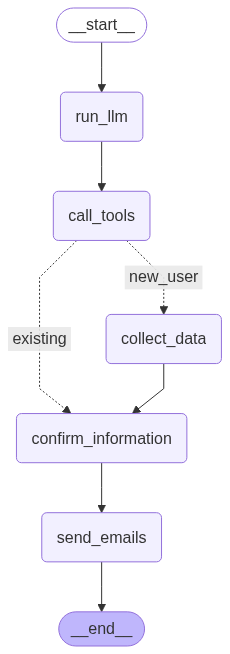

In [25]:
workflow=StateGraph(GraphState)

workflow.add_node("run_llm",run_llm)
workflow.add_node("call_tools",call_tools)
workflow.add_node("collect_data",collect_data)
workflow.add_node("send_emails",send_emails)
workflow.add_node("confirm_information", confirm_information)
workflow.add_edge("run_llm","call_tools")
workflow.add_conditional_edges(
    "call_tools",
    lambda state: "existing" if state["user_exists"]==True else "new_user",
    {"existing": "confirm_information",
     "new_user": "collect_data"})
workflow.add_edge("collect_data","confirm_information")
workflow.add_edge("confirm_information","send_emails")
workflow.add_edge("send_emails",END)
workflow.set_entry_point("run_llm")
bot=workflow.compile()
bot

In [26]:
def conversation(state: Dict[str, Any]) -> Dict[str, Any]:
    while True:
        user_message = input("User: ")
        if user_message.lower() in ["exit",'q','quit']:
            break  # Exit the loop if the user types "exit"

        state["messages"].append(HumanMessage(content=user_message))
        state = bot.invoke(state)  # Process the state with run_llm
        print("Bot:", state['messages'][-1].content)  # Print the bot's response


In [27]:
initial_state={'messages':[HumanMessage(content="Hii, I want to book an appointment!")]}
conversation(initial_state)

User: hi
Collect Data Node Triggered
User data before collecting: None


NameError: name 'extraction_chain' is not defined

In [19]:
initial_state={'messages':[HumanMessage(content="Hii, I want to book an appointment!")]}
conversation(initial_state)

User: exit
